#### Import python files from another directory
In order to reuse code written in .py files you need to import them.
If they are from a distant folder, rather than copy-paste it into the current folder, you can write:

In [12]:
import sys
sys.path.append("../../ex02/template") # This goes up twice in the directories tree (hence in labs)
                                       # then goes down to ex02/template where your files from lab 2 are.

you can now import your desired files, for example, we can import grid_search.py with:

In [13]:
import grid_search        # You then need to call your functions using grid_search.function_name()
import grid_search as gs  # You then need to call your functions using gs.function_name()
from grid_search import * # You can call any functions of the file with function_name()

# Let's try to call generate_w from grid_search.py:
w0, w1 = generate_w(5)
print(w0, w1)

[-100.  -25.   50.  125.  200.] [-150.  -75.    0.   75.  150.]


As you can see we are now able to call functions from the grid_search.py file.

In [14]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import load_data
from gradient_descent import *
from test_utils import test
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [60]:
def compute_mse(y, tx, w):

    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss by MSE
    err = y-tx.dot(w)
    return 0.5/y.shape[0] * err.T.dot(err)
    # ***************************************************
def compute_rmse(y,tx,w):
    return np.sqrt(2*compute_mse(y,tx,w))

In [16]:
def least_squares(y, tx):
    """Calculate the least squares solution.
       returns mse, and optimal weights.
    
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
    
    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        mse: scalar.

    >>> least_squares(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]))
    (array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least squares: TODO
    w = np.linalg.solve(tx.T.dot(tx),tx.T.dot(y))
    mse = compute_mse(y,tx,w)
    # returns mse, and optimal weights
    # ***************************************************
    return w,mse



### You can test your implementation here

In [17]:
test(least_squares)
# NB:
# 
# Due to precision issues, 
# the output might not be exactly the same 
# even if you have implemented the right code.
#
# For example, the mse output expected to be
# 8.666684749742561e-33,
# but you might get some other small number
# close to zero.
#
# In this case,
# Failing the test doesn't necessarily means
# your implementation is wrong.:) 

❌ The are some issues with your implementation of `least_squares`:
**********************************************************************
File "__main__", line 13, in least_squares
Failed example:
    least_squares(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]))
Expected:
    (array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)
Got:
    (array([ 0.21212121, -0.12121212]), 2.946672814912471e-32)
**********************************************************************


### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [22]:
def load_data_from_ex02(sub_sample=True, add_outlier=False):
    """Load data and convert it to the metric system."""
    path_dataset = "height_weight_genders.csv"
    data = np.genfromtxt(
        path_dataset, delimiter=",", skip_header=1, usecols=[1, 2])
    height = data[:, 0]
    weight = data[:, 1]
    gender = np.genfromtxt(
        path_dataset, delimiter=",", skip_header=1, usecols=[0],
        converters={0: lambda x: 0 if b"Male" in x else 1})
    # Convert to metric system
    height *= 0.025
    weight *= 0.454

    # sub-sample
    if sub_sample:
        height = height[::50]
        weight = weight[::50]

    if add_outlier:
        # outlier experiment
        height = np.concatenate([height, [1.1, 1.2]])
        weight = np.concatenate([weight, [51.5/0.454, 55.3/0.454]])

    return height, weight, gender

def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x)
    x = x - mean_x
    std_x = np.std(x)
    x = x / std_x
    return x, mean_x, std_x


def build_model_data(height, weight):
    """Form (y,tX) to get regression data in matrix form."""
    y = weight
    x = height
    num_samples = len(y)
    tx = np.c_[np.ones(num_samples), x]
    return y, tx

def test_your_least_squares():
    """
    # this code should compare the optimal weights obtained 
    # by least squares vs. grid search
    """
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least square or grid search: TODO
    # this code should compare the optimal weights obtained 
    # by least squares vs. grid search
    LS_w, LS_mse = least_squares(y,tx)
    GS_mse , GS_w =18.7935410195, [71.42857142857142, 15.306122448979579]
    # ***************************************************
    print(LS_w, LS_mse)
    print(GS_w , GS_mse)

Test it here

In [23]:
test_your_least_squares()

[73.293922   13.47971243] 15.385887868829402
[71.42857142857142, 15.306122448979579] 18.7935410195


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [24]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [25]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.
    
    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.
        
    Returns:
        poly: numpy array of shape (N,d+1)
        
    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # polynomial basis function: TODO
    # this function should return the matrix formed
    return np.apply_along_axis(lambda x : [x**i for i in range(degree+1)],0, x).T
    # by applying the polynomial basis to the input data
    # ***************************************************

In [26]:
test(build_poly)

✅ Your `build_poly` passed 1 tests.


Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [39]:
from plots import *
def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # form the data to do polynomial regression.: TODO
        poly_x = build_poly(x,degree)
        # ***************************************************
        # ***************************************************
        # INSERT YOUR CODE HERE
        # least square and calculate RMSE: TODO
        weights ,mse = least_squares(y,poly_x)
        rmse = np.sqrt(2*mse)
        # ***************************************************

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()

    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.25858277667737484
Processing 3th experiment, degree=7, rmse=0.24965870360907327
Processing 4th experiment, degree=12, rmse=0.24328247483727994


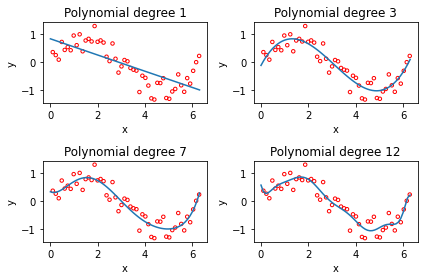

In [40]:
polynomial_regression()

Your results should look like this:

![alt text](visualize_polynomial_regression.png)

# 2 Evaluating model predication performance

Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [29]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.
    
    Args:
        x: numpy array of shape (N,), N is the number of samples.
        y: numpy array of shape (N,).
        ratio: scalar in [0,1]
        seed: integer.
        
    Returns:
        x_tr: numpy array containing the train data.
        x_te: numpy array containing the test data.
        y_tr: numpy array containing the train labels.
        y_te: numpy array containing the test labels.
        
    >>> split_data(np.arange(13), np.arange(13), 0.8, 1)
    (array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]), array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]))
    """
    # set seed
    np.random.seed(seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data based on the given ratio: TODO
    N = y.shape[0]
    lim = int(np.floor(ratio*N))
    indexes = np.random.permutation(range(N))
    
    x_tr = x[indexes[:lim]]
    x_te = x[indexes[lim:]]
    y_tr = y[indexes[:lim]]
    y_te = y[indexes[lim:]]
    return x_tr, x_te, y_tr, y_te
    # ***************************************************

In [30]:
test(split_data)

✅ Your `split_data` passed 1 tests.


Then, test your `split_data` function below.

In [37]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees.
    
    Returns:
      x_tr: numpy array
      x_te: numpy array
      y_tr: numpy array
      y_te: numpy array
      weights: weights from the least squares optimization"""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed)
    # ***************************************************
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    x_tr_poly = build_poly(x_tr, degree)
    x_te_poly = build_poly(x_te, degree)
    # ***************************************************
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate weight through least square: TODO
    weights ,mse_tr = least_squares(y_tr,x_tr_poly)
    rmse_tr = np.sqrt(2*mse_tr)
    rmse_te = np.sqrt(2*compute_mse(y_te,x_te_poly, weights))
    # ***************************************************
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively: TODO
    # ***************************************************
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))
    
    return x_tr, x_te, y_tr, y_te, weights


Demo time

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.250
proportion=0.7, degree=1, Training RMSE=0.516, Testing RMSE=0.352
proportion=0.7, degree=3, Training RMSE=0.249, Testing RMSE=0.308
proportion=0.7, degree=7, Training RMSE=0.227, Testing RMSE=0.333
proportion=0.7, degree=12, Training RMSE=0.223, Testing RMSE=0.328
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.548
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.259
proport

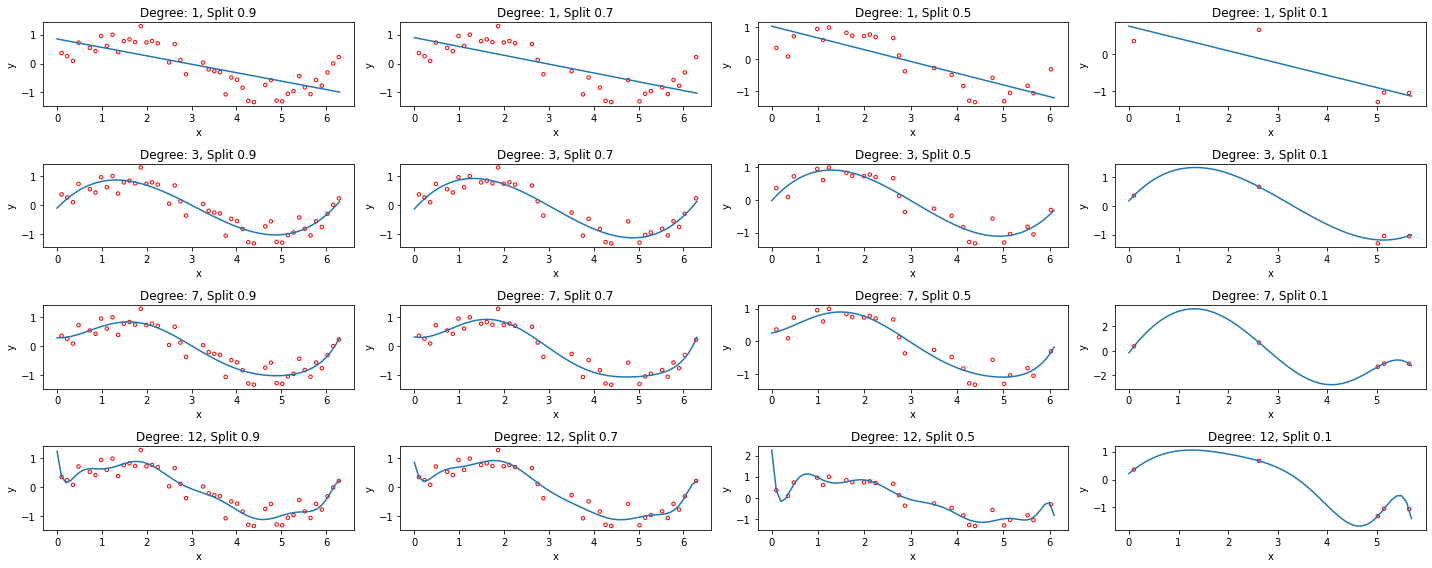

In [38]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.7, 0.5, 0.1]

# define the structure of the figure
num_row = 4
num_col = 4
axs = plt.subplots(num_row, num_col, figsize=(20,8))[1]

for ind, split_ratio in enumerate(split_ratios):
    for ind_d, degree in enumerate(degrees):
        x_tr, x_te, y_tr, y_te, w = train_test_split_demo(x, y, degree, split_ratio, seed)
        plot_fitted_curve(
            y_tr, x_tr, w, degree, axs[ind_d][ind % num_col])
        axs[ind_d][ind].set_title(f'Degree: {degree}, Split {split_ratio}')
plt.tight_layout()


Your graph should look like this:

![alt text](split_demo.png)

# Ridge Regression
Please fill in the function below.

In [56]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression.
    
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.
    
    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.

    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 0)
    array([ 0.21212121, -0.12121212])
    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 1)
    array([0.03947092, 0.00319628])
    """
    N = y.shape[0]
    D = tx.shape[1]
    w = np.linalg.solve(tx.T.dot(tx)+ lambda_*(2*N) * np.eye(D), tx.T.dot(y))
    return w

In [57]:
test(ridge_regression)

✅ Your `ridge_regression` passed 2 tests.


In [62]:
def ridge_regression_demo(x, y, degree, ratio, seed, verbose = False):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)

    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed)
    # ***************************************************
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    x_tr_poly = build_poly(x_tr, degree)
    x_te_poly = build_poly(x_te, degree)
    # ***************************************************

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ridge regression with a given lambda
        
        w = ridge_regression(y_tr, x_tr_poly, lambda_)
        rmse_tr.append(compute_rmse(y_tr, x_tr_poly, w))
        rmse_te.append(compute_rmse(y_te, x_te_poly, w))
        # ***************************************************
        if verbose :
            print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

Demo time

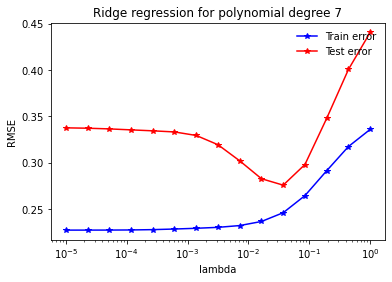

In [63]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)


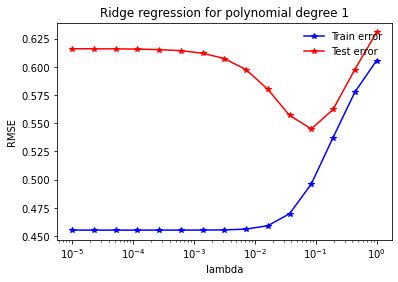

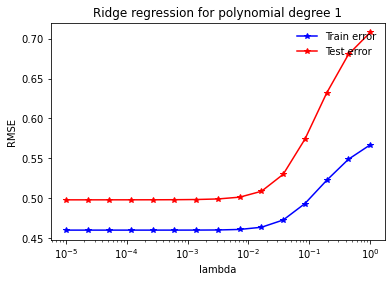

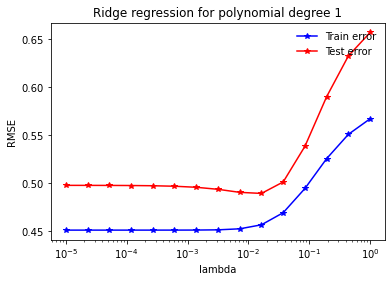

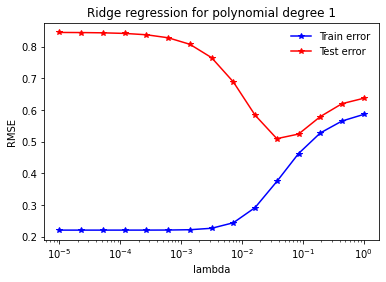

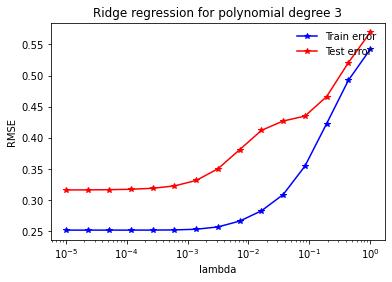

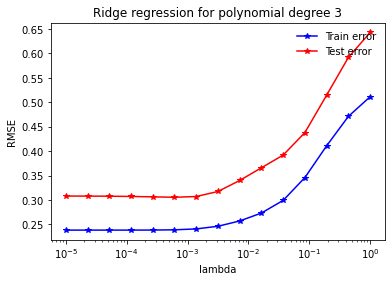

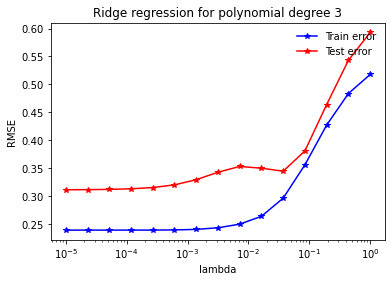

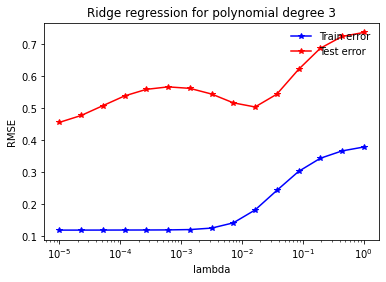

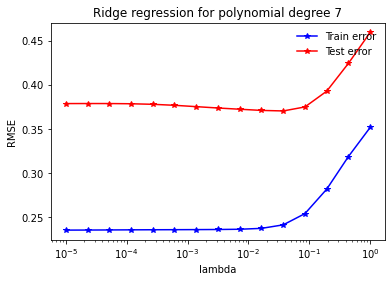

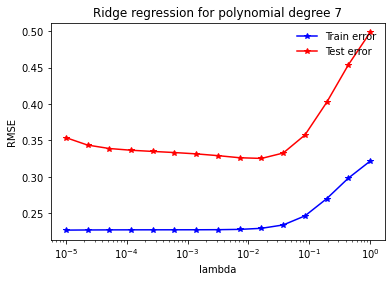

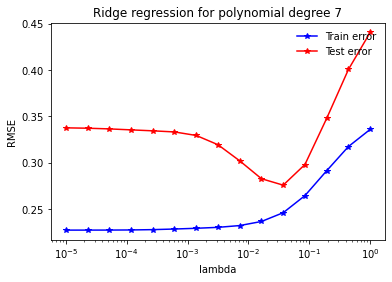

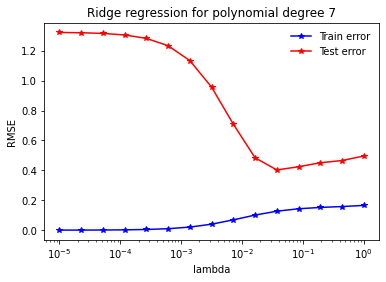

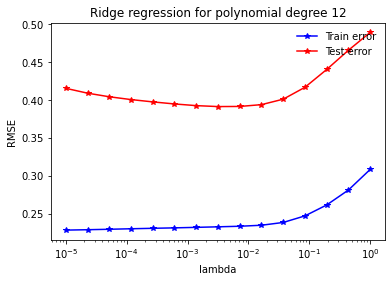

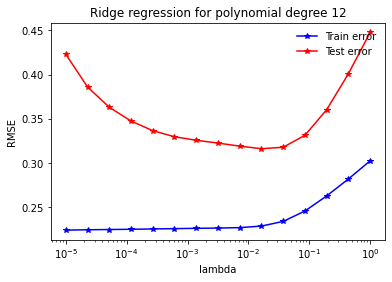

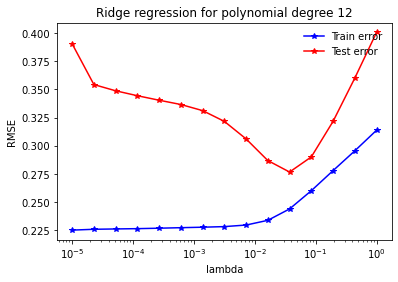

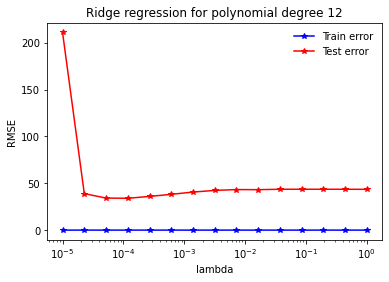

In [68]:
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.7, 0.5, 0.1]


for ind_d, degree in enumerate(degrees):
    for ind, split_ratio in enumerate(split_ratios):
        ridge_regression_demo(x, y, degree, split_ratio, seed)
        plt.show()


Your plot should look like:

![alt text](ridge_regression.png)